# First experiment: awake / asleep


Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - accuracy: 0.8594 - loss: 0.1096 - val_accuracy: 0.8884 - val_loss: 0.0854
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.8883 - loss: 0.0839 - val_accuracy: 0.8898 - val_loss: 0.0837
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8899 - loss: 0.0824 - val_accuracy: 0.8909 - val_loss: 0.0830
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.8951 - loss: 0.0793 - val_accuracy: 0.8914 - val_loss: 0.0819
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.8955 - loss: 0.0790 - val_accuracy: 0.8907 - val_loss: 0.0818
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.8919 - loss: 0.0822 - val_accuracy: 0.8901 - val_loss: 0.0816
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.8956 - loss: 0.0788 - val_accuracy: 0.8910 - val_loss: 0.0813
Epoch 8/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.9004 - loss: 0.0760 - 

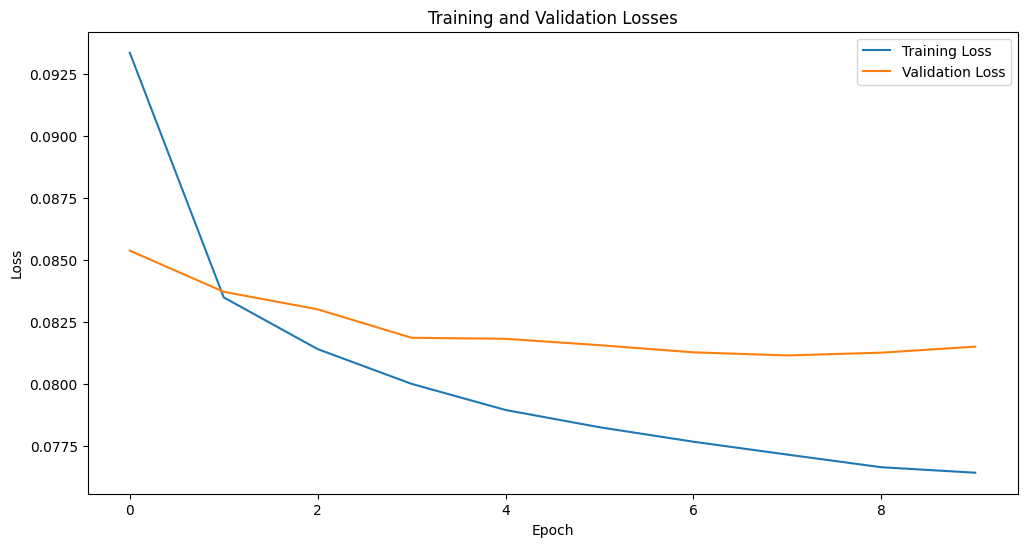

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
Confusion Matrix:


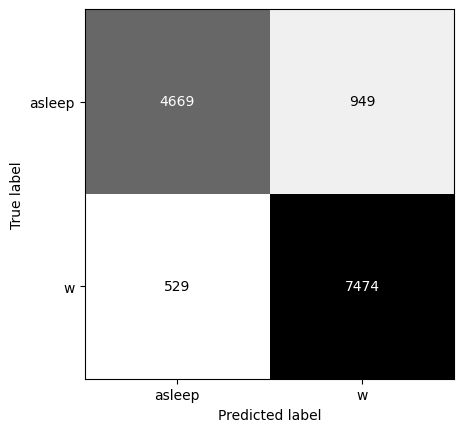

F1 Score per class:  [0.86335059 0.9100207 ]
Micro F1 Score:  0.891491079950077
Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.8955 - loss: 0.0792 - val_accuracy: 0.8992 - val_loss: 0.0762
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - accuracy: 0.8973 - loss: 0.0782 - val_accuracy: 0.8996 - val_loss: 0.0765
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - accuracy: 0.8978 - loss: 0.0778 - val_accuracy: 0.8986 - val_loss: 0.0767
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.8987 - loss: 0.0772 - val_accuracy: 0.8972 - val_loss: 0.0769
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.9017 - loss: 0.0755 - val_accuracy: 0.8989 - val_loss: 0.0769
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.8997 - loss: 0.0766 - val_accuracy: 0.8981 - val_loss: 0.0770
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.9006 - loss: 0.0757 - val_accuracy: 0.8983 - val_loss: 0.0772
Epoch 8/10

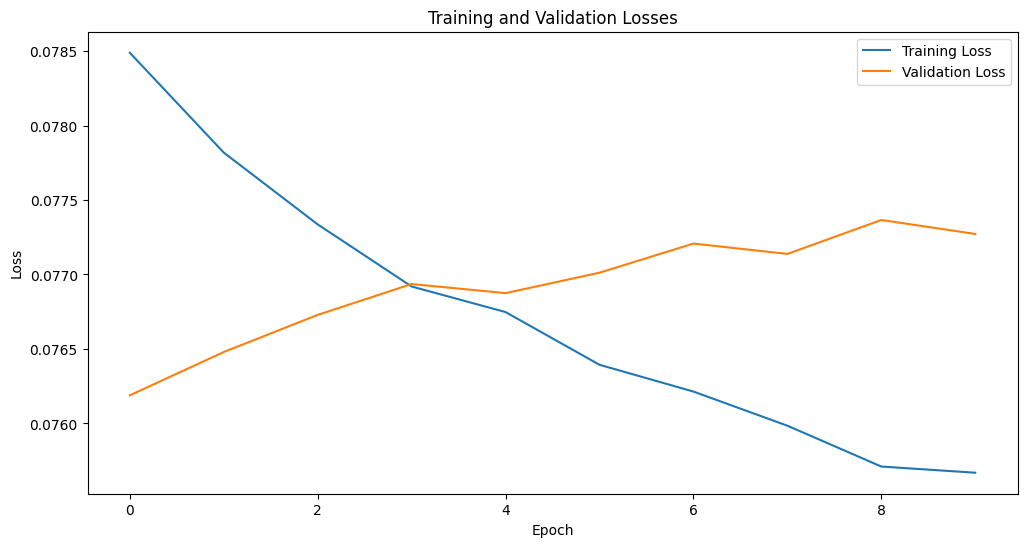

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
Confusion Matrix:


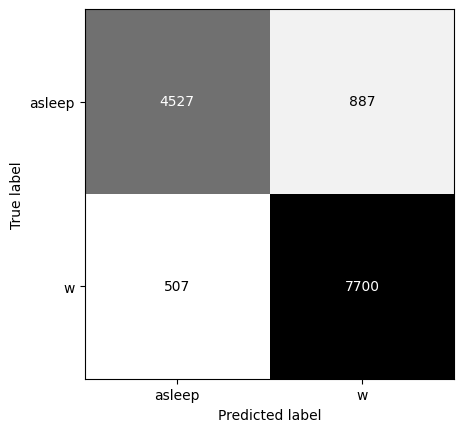

F1 Score per class:  [0.86657734 0.91699416]
Micro F1 Score:  0.8976580280449307
Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.8974 - loss: 0.0778 - val_accuracy: 0.9024 - val_loss: 0.0739
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.8995 - loss: 0.0756 - val_accuracy: 0.9035 - val_loss: 0.0739
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - accuracy: 0.8982 - loss: 0.0775 - val_accuracy: 0.9018 - val_loss: 0.0740
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - accuracy: 0.9014 - loss: 0.0763 - val_accuracy: 0.9021 - val_loss: 0.0740
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.8979 - loss: 0.0772 - val_accuracy: 0.9016 - val_loss: 0.0742
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.9017 - loss: 0.0751 - val_accuracy: 0.9018 - val_loss: 0.0742
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9020 - loss: 0.0761 - val_accuracy: 0.9014 - val_loss: 0.0743
Epoch 8/1

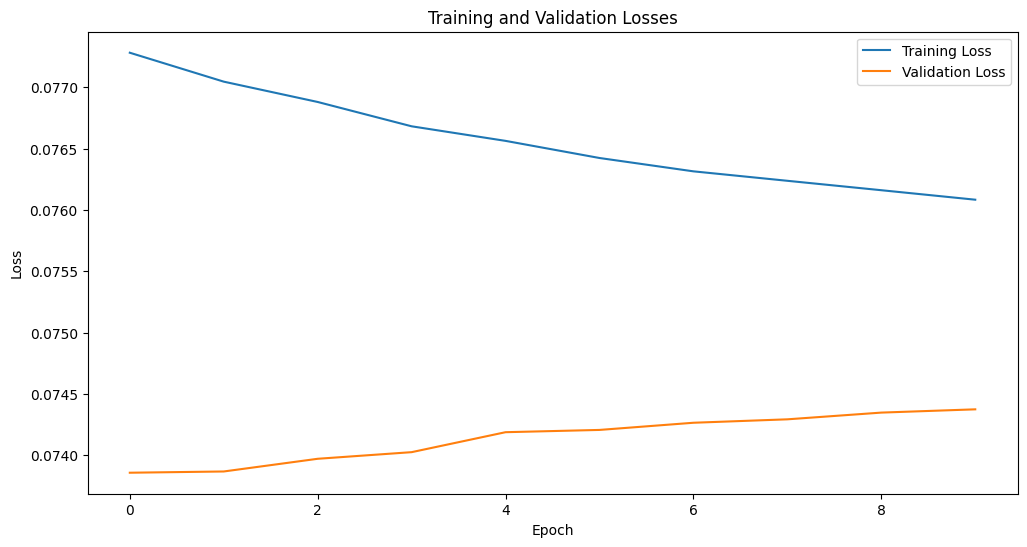

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
Confusion Matrix:


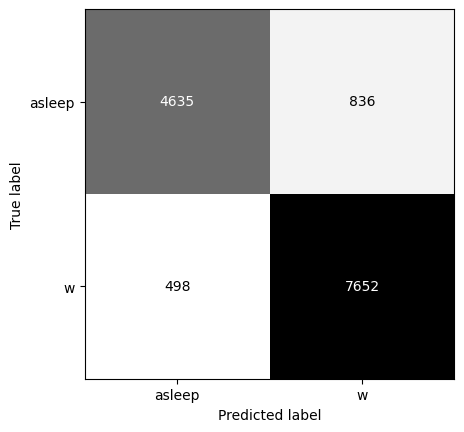

F1 Score per class:  [0.87419842 0.91982209]
Micro F1 Score:  0.902062990969826
2504/2504 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_208 (Dense)               │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,621 (29.77 KB)

 Trainable params: 3,810 (14.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,811 (14.89 KB)

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from keras.optimizers import SGD

# Load the data
data_1 = pd.read_csv('EEG_mouse_data_1.csv')
data_2 = pd.read_csv('EEG_mouse_data_2.csv')
data = pd.concat([data_1, data_2])

# Preprocess the data
features = data.columns[1:26]  # Select 25 features
X = data[features].values
y = data['state'].values  # Target variable

# Group 'n-rem' and 'rem' into 'asleep'
y = data['state'].replace(['n', 'r'], 'asleep').values


# Convert labels to integer values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert integer labels to categorical
y = to_categorical(y)

# Define the MLP model
model = Sequential()
model.add(Input(shape=(25,))) # Input layer with 25 features
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Number of neurons equals number of classes

# Define your learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.3)

# Pass the learning rate to the optimizer
sgd = SGD(learning_rate=lr_schedule, momentum=0.5)

model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

# Use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_val = scaler.transform(X_val)  # Transform the validation data

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_val)
    
    print('Confusion Matrix:\n')
    # Compute confusion matrix
    cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

    # Create ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    # Plot confusion matrix with black text
    disp.plot(cmap='binary', colorbar=False, values_format='d')
    plt.show()
        
    confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
    
    f1_scores_per_class = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average=None)
    f1_score_micro = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro')

    print('F1 Score per class: ', f1_scores_per_class)
    print('Micro F1 Score: ', f1_score_micro)
    
# Save the model's predictions on the test set
test_data = pd.read_csv('EEG_mouse_data_test.csv')
X_test = test_data[features].values  # Use the same features as the training data
X_test = scaler.transform(X_test)  # Use the same scaler fitted on the last training fold
test_predictions = model.predict(X_test)

model.summary()

# Second experiment awake / n-rem / rem


Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.7895 - loss: 0.1185 - val_accuracy: 0.8548 - val_loss: 0.0752
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.8519 - loss: 0.0760 - val_accuracy: 0.8583 - val_loss: 0.0707
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.8554 - loss: 0.0711 - val_accuracy: 0.8681 - val_loss: 0.0676
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8648 - loss: 0.0688 - val_accuracy: 0.8738 - val_loss: 0.0656
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.8731 - loss: 0.0658 - val_accuracy: 0.8753 - val_loss: 0.0645
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - accuracy: 0.8719 - loss: 0.0661 - val_accuracy: 0.8764 - val_loss: 0.0638
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.8710 - loss: 0.0668 - val_accuracy: 0.8765 - val_loss: 0.0633
Epoch 8/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - accuracy: 0.8751 - loss: 0.0647 - 

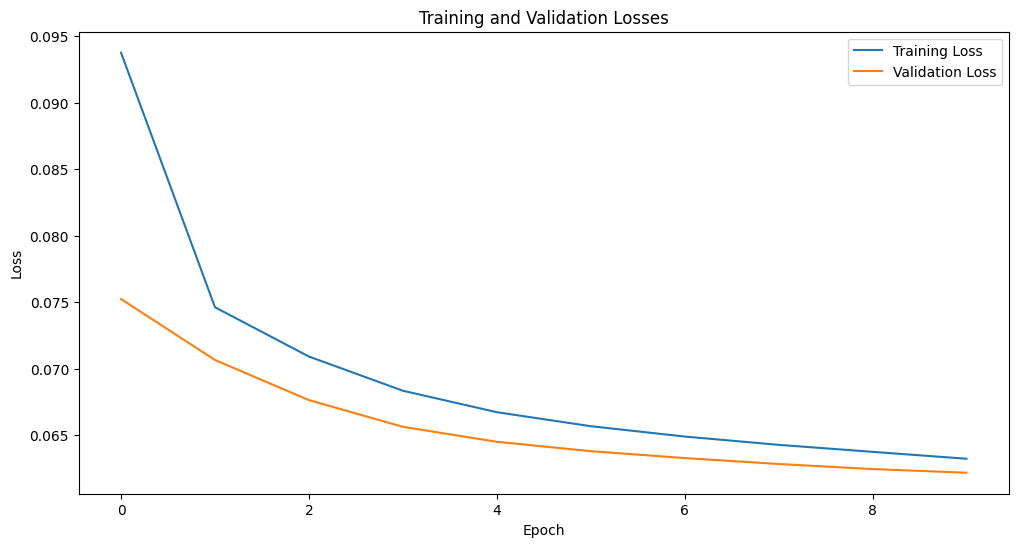

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
Confusion Matrix:


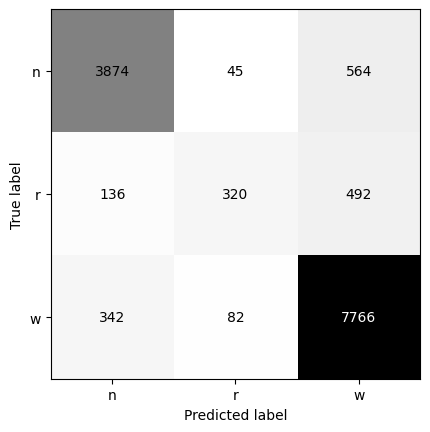

F1 Score per class:  [0.87696661 0.45878136 0.91300259]
Micro F1 Score:  0.8780559430291461
Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - accuracy: 0.8778 - loss: 0.0627 - val_accuracy: 0.8798 - val_loss: 0.0620
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.8771 - loss: 0.0630 - val_accuracy: 0.8790 - val_loss: 0.0619
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8770 - loss: 0.0620 - val_accuracy: 0.8792 - val_loss: 0.0617
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - accuracy: 0.8825 - loss: 0.0607 - val_accuracy: 0.8797 - val_loss: 0.0615
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.8799 - loss: 0.0610 - val_accuracy: 0.8799 - val_loss: 0.0614
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8795 - loss: 0.0615 - val_accuracy: 0.8797 - val_loss: 0.0611
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8787 - loss: 0.0612 - val_accuracy: 0.8797 - val_loss: 0.060

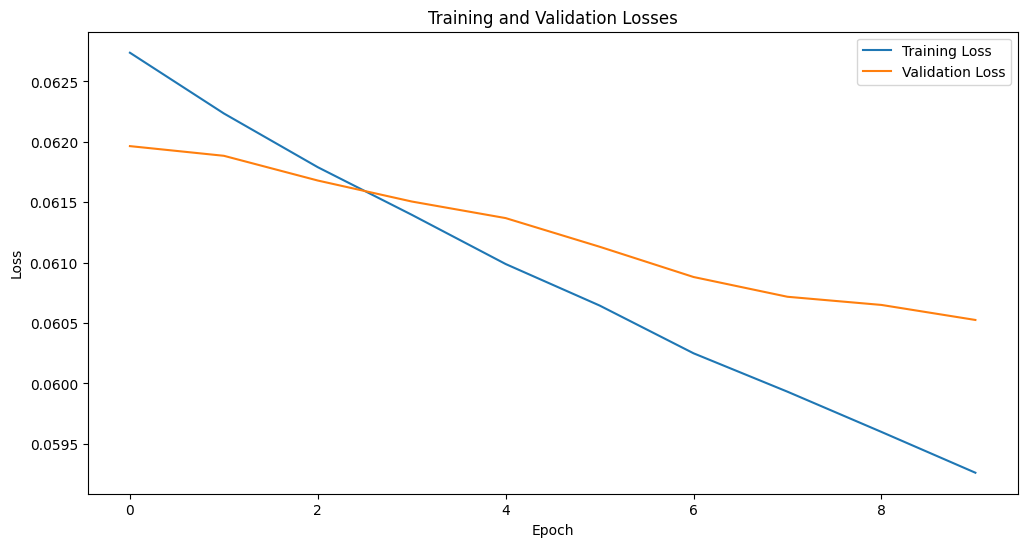

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step
Confusion Matrix:


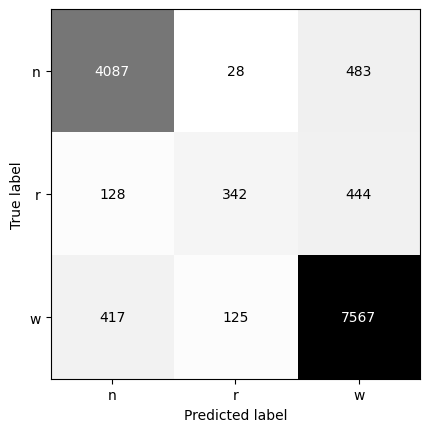

F1 Score per class:  [0.88559047 0.48545067 0.91152201]
Micro F1 Score:  0.8806989207840834
Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - accuracy: 0.8804 - loss: 0.0603 - val_accuracy: 0.8825 - val_loss: 0.0601
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.8826 - loss: 0.0597 - val_accuracy: 0.8815 - val_loss: 0.0603
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.8888 - loss: 0.0574 - val_accuracy: 0.8811 - val_loss: 0.0602
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.8872 - loss: 0.0577 - val_accuracy: 0.8805 - val_loss: 0.0602
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.8847 - loss: 0.0590 - val_accuracy: 0.8803 - val_loss: 0.0603
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8855 - loss: 0.0580 - val_accuracy: 0.8828 - val_loss: 0.0602
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.8873 - loss: 0.0585 - val_accuracy: 0.8813 - val_loss: 0.060

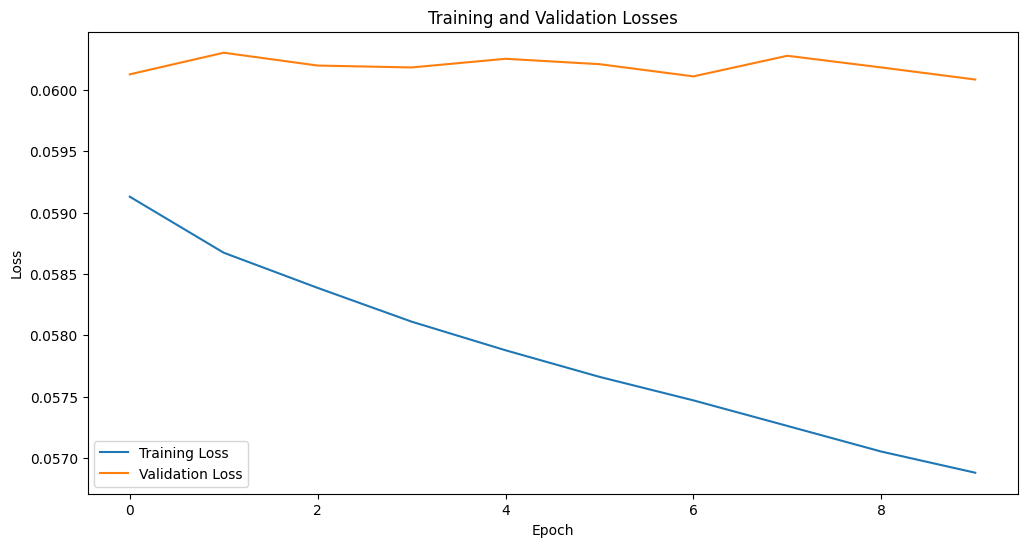

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
Confusion Matrix:


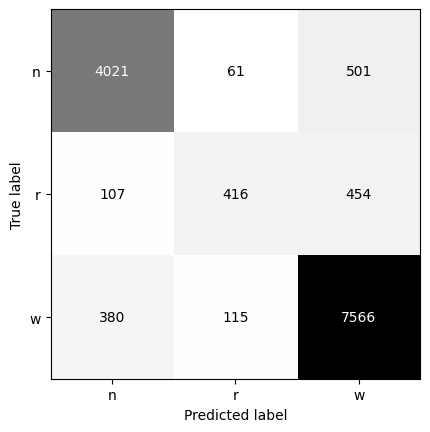

F1 Score per class:  [0.88461115 0.53027406 0.91255578]
Micro F1 Score:  0.8812128331253212
2504/2504 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 100)            │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,008 (70.35 KB)

 Trainable params: 9,003 (35.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,005 (35.18 KB)

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense, Input   
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from keras.optimizers import SGD

# Load the data
data_1 = pd.read_csv('EEG_mouse_data_1.csv')
data_2 = pd.read_csv('EEG_mouse_data_2.csv')
data = pd.concat([data_1, data_2])

# Preprocess the data
features = data.columns[1:26]  # Select 25 features
X = data[features].values
y = data['state'].values  # Target variable



# Convert labels to integer values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert integer labels to categorical
y = to_categorical(y)

# Define the MLP model
model = Sequential()
sgd_momentum = SGD(learning_rate=0.01, momentum=0.5)
model.add(Input(shape=(25,))) # Input layer with 25 features
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))  # Number of neurons equals number of classes

model.compile(loss='mean_squared_error', optimizer=sgd_momentum, metrics=['accuracy'])

# Use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_val = scaler.transform(X_val)  # Transform the validation data

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_val)
    
    print('Confusion Matrix:\n')
    # Compute confusion matrix
    cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

    # Create ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    # Plot confusion matrix with black text
    disp.plot(cmap='binary', colorbar=False, values_format='d')
    plt.show()
        
    confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
    
    f1_scores_per_class = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average=None)
    f1_score_micro = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro')

    print('F1 Score per class: ', f1_scores_per_class)
    print('Micro F1 Score: ', f1_score_micro)
    
# Save the model's predictions on the test set
test_data = pd.read_csv('EEG_mouse_data_test.csv')
X_test = test_data[features].values  # Use the same features as the training data
X_test = scaler.transform(X_test)  # Use the same scaler fitted on the last training fold
test_predictions = model.predict(X_test)

model.summary()

# Competition

# Feature Selection 

Uses the SelectKBest class from the scikit-learn library to select the top 25 features based on the chi-squared statistical test for non-negative features. This is a form of univariate feature selection which works by selecting the best features based on univariate statistical tests.


## MLP model

In [ ]:
# Load the data
data_1 = pd.read_csv('EEG_mouse_data_1.csv')
data_2 = pd.read_csv('EEG_mouse_data_2.csv')
data = pd.concat([data_1, data_2])

# Preprocess the data
features = data.columns[[2, 7, 1, 4, 3, 12, 6, 5, 11, 13, 15, 14, 8, 10, 16, 17, 18, 9, 64, 70, 71, 75, 76, 73, 72]]

X = data[features].values
y = data['state'].values  # Target variable


# Convert labels to integer values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert integer labels to categorical
y = to_categorical(y)

# Define the MLP model
model = Sequential()
model.add(Input(shape=(25,))) # Input layer with 25 features

model.add(Dense(512, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))

model.add(Dense(y.shape[1], activation='softmax'))  # Number of neurons equals number of classes

# Define your learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.2)

# Pass the learning rate to the optimizer
sgd = SGD(learning_rate=lr_schedule)
sgd_with_momentum = SGD(learning_rate=lr_schedule, momentum=0.9)
adam = keras.optimizers.Adam(learning_rate=0.001)
nadam = keras.optimizers.Nadam(learning_rate=0.001)
adamax = keras.optimizers.Adamax(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['accuracy'])

# Use 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_val = scaler.transform(X_val)  # Transform the validation data

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    y_pred = model.predict(X_val)
    
    print('Confusion Matrix:\n')
    # Compute confusion matrix
    cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

    # Create ConfusionMatrixDisplay instance
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

    # Plot confusion matrix with black text
    disp.plot(cmap='binary', colorbar=False, values_format='d')
    plt.show()
        
    confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
    
    f1_scores_per_class = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average=None)
    f1_score_micro = f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro')

    print('F1 Score per class: ', f1_scores_per_class)
    print('Micro F1 Score: ', f1_score_micro)
   
   
model.summary() 
    

# implementing a grid search to optimize a Keras neural network model. 

The `create_model` function defines the architecture of the neural network model, which includes an input layer, a variable number of hidden layers, and an output layer. The number of neurons in the hidden layers, the activation function, the weight initialization method, and the optimizer are all parameters that can be tuned.

The `KerasClassifier` is a wrapper that allows the Keras model to be used like a Scikit-learn estimator.

The grid search parameters are defined as lists of possible values for the optimizer, initialization mode, activation function, number of neurons, number of layers, number of epochs, and batch size.

The `GridSearchCV` function from Scikit-learn is then used to perform the grid search over the specified parameter grid on the model. The model is trained and evaluated multiple times, each time with a different combination of parameters. The combination of parameters that results in the best model performance is then printed out.

In [ ]:

# Load the data
data_1 = pd.read_csv('EEG_mouse_data_1.csv')
data_2 = pd.read_csv('EEG_mouse_data_2.csv')
data = pd.concat([data_1, data_2])

# Preprocess the data
features = data.columns[1:26]  # Select 25 features
X = data[features].values
y = data['state'].values  # Target variable


# Convert labels to integer values
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert integer labels to categorical
y = to_categorical(y)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(25,))) # Input layer with 25 features

    model.add(Dense(512, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid'))
    

    model.add(Dense(y.shape[1], activation='softmax'))  
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Competition 

Save the model's predictions on the test set to a file named `test_pred.npy`. The predictions should be in the form of a NumPy array with shape `(n_samples,)` where `n_samples` is the number of samples in the test set. Each element in the array should be an integer corresponding to the predicted class label for that sample.

In [ ]:
# Save the model's predictions on the test set
test_data = pd.read_csv('EEG_mouse_data_test.csv')
X_test = test_data[features].values  # Use the same features as the training data
X_test = scaler.transform(X_test)  # Use the same scaler fitted on the last training fold
test_predictions = model.predict(X_test)

with open('test_pred.npy', 'wb') as f:
    np.save(f, test_predictions.argmax(axis=1))